In [103]:
import geopandas as gpd
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from rasterio.mask import mask
from matplotlib.colors import ListedColormap

In [104]:
import warnings
warnings.filterwarnings('ignore')

# Predicting Population using Area

In [105]:
# number of counties in Wisconsin
df = gpd.read_file('counties.geojson')
len(df)

72

In [106]:
df.head()

,NAME,POP100,geometry
0,Racine County,195408,"POLYGON ((-88.07073 42.66976, -88.06897 42.669..."
1,Clark County,34690,"POLYGON ((-90.55875 44.42221, -90.53398 44.422..."
2,Wood County,74749,"POLYGON ((-89.72464 44.33712, -89.72460 44.338..."
3,Rusk County,14755,"POLYGON ((-90.92517 45.37935, -90.92515 45.379..."
4,Ozaukee County,86395,"POLYGON ((-87.89269 43.19202, -87.89265 43.192..."


<Axes: >

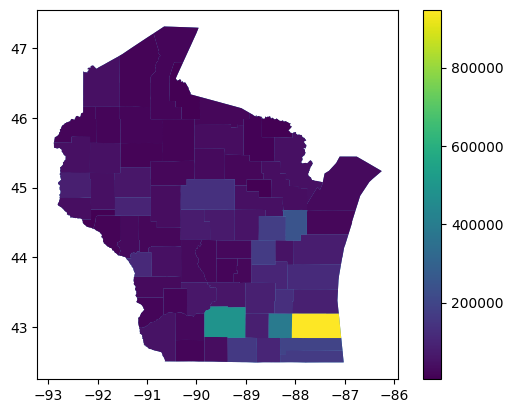

In [107]:
# population of each county in wisconsin represented by a geopandas plot
ax = df.plot()
df.plot(ax=ax,legend = True,column = "POP100")

In [108]:
conn = sqlite3.connect("counties_tracts.db")
pd.read_sql("""SELECT * FROM sqlite_master""", conn)
arealand = pd.read_sql("""SELECT * FROM counties""", conn)["AREALAND"]
df["AREALAND"] = arealand

train,test = train_test_split(df,random_state=250,test_size=0.25)
df.head()

,NAME,POP100,geometry,AREALAND
0,Racine County,195408,"POLYGON ((-88.07073 42.66976, -88.06897 42.669...",861533739
1,Clark County,34690,"POLYGON ((-90.55875 44.42221, -90.53398 44.422...",3133378070
2,Wood County,74749,"POLYGON ((-89.72464 44.33712, -89.72460 44.338...",2054044751
3,Rusk County,14755,"POLYGON ((-90.92517 45.37935, -90.92515 45.379...",2366092584
4,Ozaukee County,86395,"POLYGON ((-87.89269 43.19202, -87.89265 43.192...",603514413


In [109]:
# names of different counties in the test dataset
test["NAME"].tolist()

['Dane County',
 'Juneau County',
 'Taylor County',
 'Vilas County',
 'Rusk County',
 'Price County',
 'Jackson County',
 'Waushara County',
 'Pepin County',
 'Douglas County',
 'Ashland County',
 'Milwaukee County',
 'Waupaca County',
 'Richland County',
 'Lafayette County',
 'Washburn County',
 'Dunn County',
 'Bayfield County']

In [110]:
'''The amount of variance in the POP100 a LinearRegression model can explain 
 based only on AREALAND?'''
model = LinearRegression()
model.fit(train[["AREALAND"]],train["POP100"])
model.score(test[["AREALAND"]],test["POP100"])

0.016720430179409274

In [111]:
'''predicted population of a county with 400 square 
miles of area, according to the model?'''
predict_df = pd.DataFrame({"AREALAND":[400*2.59*1000000]})
q5_y = model.predict(predict_df)
float(q5_y[0])

90000.07422783462

In [112]:

conn = sqlite3.connect("counties_tracts.db")
pd.read_sql("""SELECT * FROM sqlite_master""", conn)
counties = pd.read_sql("""SELECT * FROM counties""", conn)

hu = pd.read_sql("""SELECT * FROM tracts""", conn).groupby("COUNTY").sum()

hu_100 = pd.merge(counties,hu, on = "COUNTY")["HU100"]
df["HU100"] = hu_100

train_6,test_6 = train_test_split(df,random_state=250,test_size=0.25)


# Predicting Population using Housing Units

In [113]:
#counties in the test dataset
pop_housing = test_6["NAME"].tolist()
pop_housing

['Dane County',
 'Juneau County',
 'Taylor County',
 'Vilas County',
 'Rusk County',
 'Price County',
 'Jackson County',
 'Waushara County',
 'Pepin County',
 'Douglas County',
 'Ashland County',
 'Milwaukee County',
 'Waupaca County',
 'Richland County',
 'Lafayette County',
 'Washburn County',
 'Dunn County',
 'Bayfield County']

In [114]:
#HU100 values for the counties in the test dataset
def hu_test():
    fin = {}
    for k in pop_housing:
        val = int(df.loc[df['NAME']==k]['HU100'])
        fin[k]= val
    return fin
hu_test()

{'Dane County': 216022,
 'Juneau County': 14669,
 'Taylor County': 10582,
 'Vilas County': 25116,
 'Rusk County': 8883,
 'Price County': 11120,
 'Jackson County': 9727,
 'Waushara County': 14843,
 'Pepin County': 3579,
 'Douglas County': 22825,
 'Ashland County': 9656,
 'Milwaukee County': 418053,
 'Waupaca County': 25396,
 'Richland County': 8868,
 'Lafayette County': 7230,
 'Washburn County': 12979,
 'Dunn County': 17964,
 'Bayfield County': 12999}

In [115]:
'''Amount of variance in the POP100 a LinearRegression model can explain based only on HU100'''
model = LinearRegression()
scores = cross_val_score(model,train_6[['HU100']],train_6['POP100'])
float(scores.mean())

0.9739348181232653

In [116]:
'''standard deviation of the cross validation scores from variance scores'''
float(np.std(scores))

0.01693954236334351

In [117]:
''' formula relating POP100 and HU100'''
model.fit(train_6[['HU100']],train_6['POP100'])
coeff = round(model.coef_[0],2 )
intercept = round(model.intercept_,2)
f"POP100 = {coeff}*HU100 + {intercept}"

'POP100 = 2.47*HU100 + -9276.89'

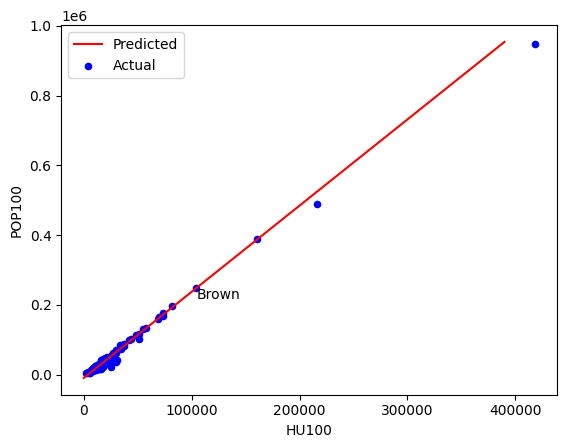

In [118]:
'''visual relationship between HU100 and POP100'''
predict_df = pd.DataFrame({"HU100": range(0, 400000, 10000)})
predict_df["POP100"] = model.predict(predict_df)
ax = predict_df.plot.line(x="HU100", y="POP100", color="r")
df.plot.scatter(x="HU100", y="POP100", ax=ax, color="BLUE")
ax.legend(["Predicted","Actual"])
ax.text(int(df[df['NAME'] == "Brown County"]["HU100"]),int(df[df['NAME'] == "Brown County"]["POP100"]),"Brown", va = "top" );

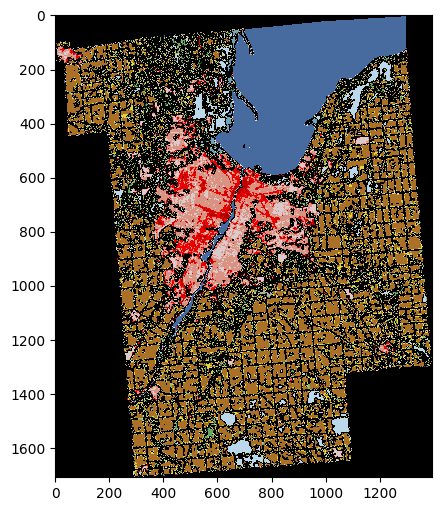

In [119]:
'''Visualizig Brown County'''
land = rasterio.open("zip:land.zip!wi.tif")
brown = df[df['NAME']=="Brown County"] 

matrix, _ = mask(land, brown.to_crs(land.crs)["geometry"], crop=True)
matrix = matrix[0]

c = np.zeros((256,3))
c[0] = [0.00000000000, 0.00000000000, 0.00000000000]
c[11] = [0.27843137255, 0.41960784314, 0.62745098039]
c[12] = [0.81960784314, 0.86666666667, 0.97647058824]
c[21] = [0.86666666667, 0.78823529412, 0.78823529412]
c[22] = [0.84705882353, 0.57647058824, 0.50980392157]
c[23] = [0.92941176471, 0.00000000000, 0.00000000000]
c[24] = [0.66666666667, 0.00000000000, 0.00000000000]
c[31] = [0.69803921569, 0.67843137255, 0.63921568628]
c[41] = [0.40784313726, 0.66666666667, 0.38823529412]
c[42] = [0.10980392157, 0.38823529412, 0.18823529412]
c[43] = [0.70980392157, 0.78823529412, 0.55686274510]
c[51] = [0.64705882353, 0.54901960784, 0.18823529412]
c[52] = [0.80000000000, 0.72941176471, 0.48627450980]
c[71] = [0.88627450980, 0.88627450980, 0.75686274510]
c[72] = [0.78823529412, 0.78823529412, 0.46666666667]
c[73] = [0.60000000000, 0.75686274510, 0.27843137255]
c[74] = [0.46666666667, 0.67843137255, 0.57647058824]
c[81] = [0.85882352941, 0.84705882353, 0.23921568628]
c[82] = [0.66666666667, 0.43921568628, 0.15686274510]
c[90] = [0.72941176471, 0.84705882353, 0.91764705882]
c[95] = [0.43921568628, 0.63921568628, 0.72941176471]
custom_cmap = ListedColormap(c)

fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(matrix, vmin=0, vmax=255,cmap =custom_cmap )

In [120]:
''' The portion of Brown County that  is open water '''
land_use = {"open_water": 11,
            "ice_snow": 12,
            "developed_open": 21,
            "developed_low": 22,
            "developed_med": 23,
            "developed_high": 24,
            "barren": 31,
            "deciduous": 41,
            "evergreen": 42,
            "mixed_forest": 43,
            "dwarf_scrub": 51,
            "shrub_scrub": 52,
            "grassland": 71,
            "sedge": 72,
            "lichens": 73,
            "moss": 74,
            "pasture": 81,
            "crops": 82,
            "woody_wetlands": 90,
            "herbacious_wetlands": 95}

total_brown = (matrix != 0).astype(int).sum()

water_brown = ((matrix != 0)&(matrix == 11)).astype(int).sum()

water_brown/total_brown

0.13797526789725206

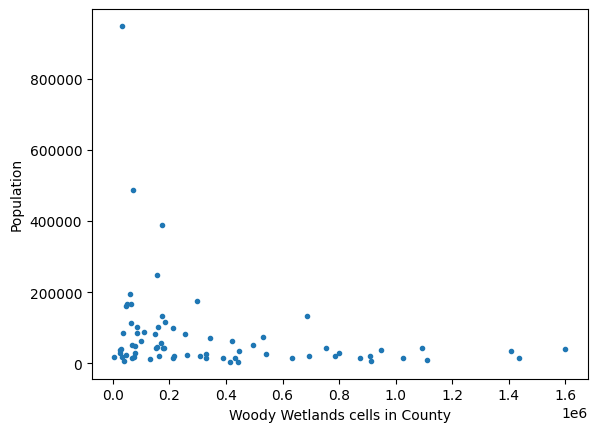

In [121]:
'''Relationship Between POP100 and  Woody Wetlands cells '''

counties_list = counties["NAME"].tolist()
def pop_woody_wetland():
    fin = {}
    for county in counties_list:
        pop = int(df[df['NAME'] == county]["POP100"])
        county_geo = df[df['NAME']==county] 
        
        matrix, _ = mask(land, county_geo.to_crs(land.crs)["geometry"], crop=True)
        matrix = matrix[0]
        total =  ((matrix != 0)&(matrix ==90)).astype(int).sum()
        fin[total] = pop
    return fin

pop_woody_wetland = pop_woody_wetland() #data for woody_wetlands

pop_woody_wetland = pd.Series(pop_woody_wetland)
ax =pop_woody_wetland.plot(style='.')
plt.xlabel("Woody Wetlands cells in County")
plt.ylabel("Population");

In [122]:
geodata = gpd.read_file('tracts.shp')
geodata.head()

,GEOID,POP100,geometry
0,55001950204,1646,"POLYGON ((-90.02638 44.08721, -90.02627 44.089..."
1,55009940002,4698,"POLYGON ((-88.15018 44.51202, -88.15010 44.513..."
2,55061990000,0,"POLYGON ((-87.53727 44.33179, -87.53547 44.334..."
3,55009020100,5817,"POLYGON ((-87.93753 44.67821, -87.89338 44.678..."
4,55009010100,6506,"POLYGON ((-88.06825 44.45368, -88.05841 44.461..."


'\nThis graph shows us that the model seems to rely on "developed_med" land type the most. \nWe can think of these coeffecients as how much impact it has on determining population (slope).\nIt means that our linear regression model for predicting population will depend majorly on the \nland types like "developed_med" and "developed_low"\n'

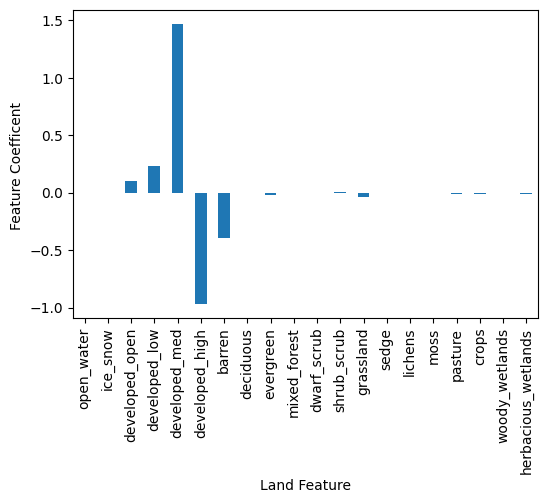

In [123]:
'''What features does your model rely on most?'''

def imp_features():
    imp_features_data = geodata.copy()
    fin = pd.DataFrame()

    for row in imp_features_data['GEOID']:
        county_geo = imp_features_data[imp_features_data['GEOID']==row]
        matrix, _ = mask(land, county_geo.to_crs(land.crs)["geometry"], crop=True)
        matrix = matrix[0]
        
        for land_type in land_use:

            total =  ((matrix != 0)&(matrix == land_use[land_type] )).astype(int).sum()
            imp_features_data.loc[geodata['GEOID']==row,land_type] = total
            
    return imp_features_data
            
        
imp_features=imp_features()

train_imp_features,test_imp_features = train_test_split(imp_features,random_state=320,test_size=0.25)

model = LinearRegression()
xcols = list(land_use)
ycol = "POP100"

model.fit(train_imp_features[xcols], train_imp_features[ycol]);


pd.Series(model.coef_, index=xcols).plot.bar(figsize=(6,4));
plt.xlabel("Land Feature")
plt.ylabel("Feature Coefficent ");


'''
This graph shows us that the model seems to rely on "developed_med" land type the most. 
We can think of these coeffecients as how much impact it has on determining population (slope).
It means that our linear regression model for predicting population will depend majorly on the 
land types like "developed_med" and "developed_low"
'''

In [124]:
model1 = LinearRegression()
model2 = LinearRegression()

model1_cross_scores = cross_val_score(model1,train_imp_features[['developed_med']], train_imp_features[ycol])
model2_cross_scores = cross_val_score(model2, train_imp_features[['developed_low']], train_imp_features[ycol])

In [125]:
model1_cross_scores

array([0.31938219, 0.35876241, 0.40030015, 0.39603861, 0.43947777])

In [126]:
model2_cross_scores

array([0.18794584, 0.08527359, 0.13307096, 0.14224041, 0.14961725])

In [127]:
means = pd.Series({"model1": model1_cross_scores.mean(),
                   "model2": model2_cross_scores.mean(),})
means

model1    0.382792
model2    0.139630
dtype: float64

In [128]:
'''Scoring of recommended model against the test dataset'''
model1.fit( train_imp_features[['developed_med']] ,train_imp_features[ycol])
model1_score = model1.score( test_imp_features[['developed_med']] ,test_imp_features[ycol])
round((model1_score),2)


#Model 1 is better for this prediction task since it is able to account for 
# 35% of the variance and has a higher average cross validation score.

'\nModel 1 is better for this prediction task since it is able to account for\n35% of the variance and has a higher average cross validation score.\n'